In [1]:
from mlguess.keras.models import CategoricalDNN
from mlguess.keras.losses import evidential_cat_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from hagelslag.evaluation.ProbabilityMetrics import DistributedReliability, DistributedROC
from metpy.plots import SkewT
from metpy.units import units
# from hagelslag.evaluation.MetricPlotter import attributes_diargram
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
from collections import Counter
from keras.models import load_model
from bridgescaler import load_scaler, GroupMinMaxScaler, GroupRobustScaler, GroupStandardScaler
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from hagelslag.evaluation.MetricPlotter import performance_diagram
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj
from hagelslag.evaluation import MetricPlotter
from scipy.spatial import KDTree
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

2025-11-21 15:27:49.115433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 15:27:49.168765: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 15:27:55.104293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_parquet('/glade/campaign/cisl/aiml/ai2es/winter_ptypes/ptype_qc/mPING_hourafter_interpolated_QC2.parquet')

In [3]:
def qc_mping(df, split_date, met_vars, output_cols, max_hgt_from_sfc=5000, hgt_interval=250, scaler_type='standard', exclude_months=None, rain_thresh=-1, snow_thresh=3, other_thresh=0, temp_crossings=(1, -2), filter='TEMP_C_0_m'):
    """
    df: Pandas Dataframe of sounding data and assiciated mping reports
    split_date (string): Date to split training and validation data
    met_vars (list): Prefix for Meteorlogical variables not include the height 
    ouput_cols (list): Output columns (p-types)
    max_hgt_from_sfc (int): Max level above the surface to for each variable (meters)
    hgt_interval (int): How many meters between each vetical level
    scaler_type (string): Tyhpe of group scaler to use (supports "standard", "robust", and "minmax")
    exclude_months (list of ints): Interger list of numeric months to remove from the dataset
    rain_thresh (int): Filter threshold to remove all rain observations BELOW this value
    snow_thresh (int): Filter threshold to remove all snow observations ABOVE this value
    other_thresh (int): Filter threshold to remove all IP and FRZR observations ABOVE this value
    temp_crossings (tuple): (max, min) Filter to ensure temperature profile crosses both of these thresholds in the vertical profile for IP and FRZR
    filter (string): Which input variable to use for thresholds
    """    
    def one_hot(x, output_cols):
        a = np.zeros(len(output_cols))
        a[x] = 1
        return a
    
    line_cross_filter = 'TEMP_C_0_m'
    scalar_objs = {"minmax": GroupMinMaxScaler, "standard": GroupStandardScaler, "robust": GroupRobustScaler}

    # scaler = load_scaler('/glade/campaign/cisl/aiml/ptype_historical/models/winds/echo1/scalers/input_14.json')
    scaler = scalar_objs[scaler_type]()
    input_cols = [f'{var}_{height}_m' for var in met_vars for height in range(0, max_hgt_from_sfc + hgt_interval, hgt_interval)]
    groups = []
    for var in met_vars:
        groups.append([v for v in input_cols if var in v])
    
    data = {}
    mping = df.copy()
    mping['percent_max'] = mping[['ra_percent',
                                  'sn_percent',
                                  'pl_percent',
                                  'fzra_percent']].idxmax(axis=1)
    temps = [f"TEMP_C_{x}_m" for x in range(0, max_hgt_from_sfc + hgt_interval, hgt_interval)]
    dews = [f"T_DEWPOINT_C_{x}_m" for x in range(0, max_hgt_from_sfc + hgt_interval, hgt_interval)]
    if exclude_months:
        mping = mping[~mping['datetime'].dt.month.isin(exclude_months)]
    if snow_thresh is not None:
        snow = mping[((mping['percent_max'] == 'sn_percent') & (mping[filter] < snow_thresh))]
    if rain_thresh is not None:
        rain = mping[((mping['percent_max'] == 'ra_percent') & (mping[filter] > rain_thresh))]
    if other_thresh is not None:
        sleet = mping[(mping['percent_max'] == 'pl_percent') & (mping[temps].gt(temp_crossings[0]).any(axis=1)) & (mping[temps].lt(temp_crossings[1]).any(axis=1)) & (mping[filter] < other_thresh)]
        frain = mping[(mping['percent_max'] == 'fzra_percent') & (mping[temps].gt(temp_crossings[0]).any(axis=1)) & (mping[temps].lt(temp_crossings[1]).any(axis=1)) & (mping[filter] < other_thresh)]
    # if np.any([exclude_months, snow_thresh, rain_thresh, other_thresh]) is not None:
    if any(x is not None for x in [exclude_months, snow_thresh, rain_thresh, other_thresh]):
        filtered_mping = pd.concat([rain, snow, sleet, frain], axis=0)   
    else:
        filtered_mping = mping.copy()
    filtered_mping['encoded_target'] = filtered_mping[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x), output_cols))
    
    data['train'] = filtered_mping[filtered_mping['datetime'] < split_date]
    data['val'] = filtered_mping[filtered_mping['datetime'] >= split_date]
    data['train_x'] = scaler.fit_transform(data['train'][input_cols], groups=groups)
    # data['train_x'] = scaler.fit_transform(data['train'][input_cols])


    data['train_y'] = data['train']['encoded_target']
    data['val_x'] = scaler.transform(data['val'][input_cols])
    data['val_y'] = data['val']['encoded_target']

    return data, scaler

In [4]:
data_uf, scaler_uf = qc_mping(df,
                        split_date='2020-06-01',
                        met_vars=['TEMP_C', 'T_DEWPOINT_C', 'UGRD_m/s', 'VGRD_m/s'],
                        output_cols=['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent'],
                        max_hgt_from_sfc=5000,
                        hgt_interval=250,
                        scaler_type='robust',
                        exclude_months=None,
                        rain_thresh=None,
                        snow_thresh=None,
                        other_thresh=None,
                        temp_crossings=None,
                        filter=None)
print(Counter(data_uf['train']['percent_max']))

Counter({'ra_percent': 1118066, 'sn_percent': 455954, 'pl_percent': 94134, 'fzra_percent': 41264})


In [5]:
data_filtered = pd.read_parquet('/glade/campaign/cisl/aiml/ai2es/winter_ptypes/ptype_qc/QC3/train_w_RAP.parquet')
data_uf['train'].set_index('percent_max', inplace=True)
data_filtered.set_index('percent_max', inplace=True)

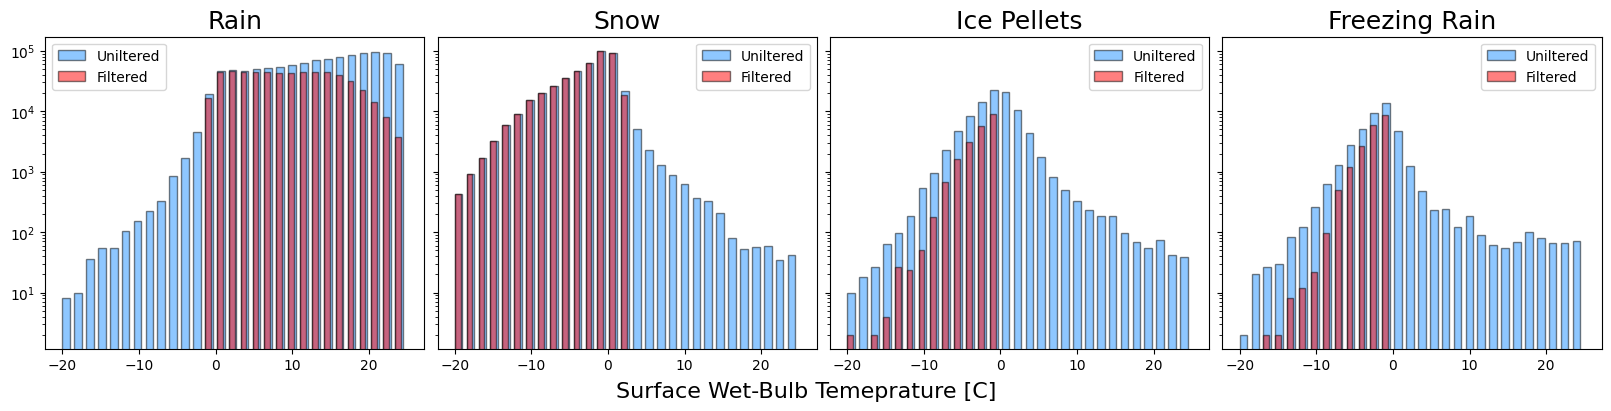

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True, constrained_layout=True)
bins = [np.linspace(-20, 25, 30), np.linspace(-20, 25, 30), np.linspace(-20, 25, 30), np.linspace(-20, 25, 30)]
ptypes = ['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent']
titles = ['Rain', 'Snow', 'Ice Pellets', 'Freezing Rain']
for i, ax in enumerate(axes.ravel()):
    ax.hist(data_uf['train'].loc[ptypes[i], 'wetbulb_temp_0m_C'], bins=bins[i], color='dodgerblue', edgecolor='k', alpha=0.5, width=1, log=True, label='Uniltered')
    ax.hist(data_filtered.loc[ptypes[i], 'wetbulb_temp_0m_C'], bins=bins[i], color='red', edgecolor='k', alpha=0.5, width=0.75, log=True, label='Filtered')

    ax.set_title(titles[i], fontsize=18)
    ax.legend()
fig.supxlabel('Surface Wet-Bulb Temeprature [C]', fontsize=16)
plt.savefig("/glade/derecho/scratch/cbecker/ptype_paper/figures/ptype_combined_histogram.png", dpi=300, bbox_inches='tight')

In [7]:
model = load_model("/glade/derecho/scratch/cbecker/ptype_model_20240909.keras", custom_objects={'loss': evidential_cat_loss})
scaler = load_scaler('/glade/derecho/scratch/cbecker/ptype_scaler_20240909.json')

W0000 00:00:1763764147.385397   70297 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [37]:
val

T_DEWPOINT_C_0_m  T_DEWPOINT_C_250_m  T_DEWPOINT_C_500_m  \
1           10.655518            9.846176            8.940982   
2           17.905518           17.959355           17.658578   
3           17.780518           17.867655           16.606670   
4           11.093018           11.741220           11.572789   
5            5.780518            3.739826            1.076141   
..                ...                 ...                 ...   
305         -5.322723           -8.912619           -6.468671   
424         -3.810028           -4.360172           -4.819081   
394         -4.826782           -7.874206           -8.593430   
499         -2.424591           -3.609867           -2.604348   
15          -6.324066          -11.157852          -16.691041   

     T_DEWPOINT_C_750_m  T_DEWPOINT_C_1000_m  T_DEWPOINT_C_1250_m  \
1              7.902916             6.715287             5.291236   
2             16.565315            14.499381            13.008617   
3             14.263469            12.130689            11.284433   
4             10.993574            10.381173             8.913067   
5              0.360450             1.600760             1.928132   
..                  ...                  ...                  ...   
305           -2.357870             1.944628             3.990926   
424           -3.568311            -5.129461            -5.173997   
394           -5.778362            -2.115679            -0.798838   
499           -0.367103             1.136386             1.296435   
15           -13.237719            -7.836143            -5.092158   

     T_DEWPOINT_C_1500_m  T_DEWPOINT_C_1750_m  T_DEWPOINT_C_2000_m  \
1               3.777329             2.485421             1.295321   
2              12.477793            11.997772            11.038593   
3              11.544347            11.520435            10.488186   
4               7.417894             5.743554             3.402116   
5               1.236933            -0.123930            -1.206031   
..                   ...                  ...                  ...   
305             4.305713             3.548417             2.077438   
424            -5.253628            -6.529875            -7.611556   
394            -1.648101            -2.852594            -4.000728   
499             0.629413            -0.334013            -1.403622   
15             -4.448817            -4.561867            -4.661754   

     T_DEWPOINT_C_2250_m  ...  wetbulb4.0_filter  wetbulb6.0_filter  \
1               0.205113  ...                0.0                0.0   
2               9.652564  ...                0.0                0.0   
3               8.889696  ...                0.0                0.0   
4               2.066808  ...                0.0                0.0   
5              -1.326106  ...                0.0                0.0   
..                   ...  ...                ...                ...   
305             0.437747  ...                0.0                0.0   
424            -7.505478  ...                0.0                0.0   
394            -5.081520  ...                0.0                0.0   
499            -2.488328  ...                0.0                0.0   
15             -4.215917  ...                0.0                0.0   

     wetbulb7.0_filter  wetbulb8.0_filter  wetbulb9.0_filter  \
1                  0.0                0.0                0.0   
2                  0.0                0.0                0.0   
3                  0.0                0.0                0.0   
4                  0.0                0.0                0.0   
5                  0.0                0.0                0.0   
..                 ...                ...                ...   
305                0.0                0.0                0.0   
424                0.0                0.0                0.0   
394                0.0                0.0                0.0   
499                0.0                0.0                0.0 

In [8]:
val = pd.read_parquet('/glade/campaign/cisl/aiml/ai2es/winter_ptypes/ptype_qc/QC3/val_w_RAP.parquet')
met_vars = ['TEMP_C', 'T_DEWPOINT_C', 'UGRD_m/s', 'VGRD_m/s']
max_hgt_from_sfc = 5000
hgt_interval = 250
vertical_atm = np.arange(0, max_hgt_from_sfc + hgt_interval, hgt_interval)
input_cols = [f'{var}_{height}_m' for var in met_vars for height in range(0, max_hgt_from_sfc + hgt_interval, hgt_interval)]

In [9]:
model_input = scaler.transform(val[input_cols])
probs, u, aleatoric, epistemic = model.predict(model_input, return_uncertainties=True, batch_size=1000)
obs = np.argmax(np.stack(val['encoded_target']), axis=1)
preds = np.argmax(probs, axis=1)

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [10]:
press = [f'PRES_Pa_{h}_m' for h in np.arange(0, 5250, 250)]
val['pred'] = preds
val['observation'] = obs

In [11]:
%%time
press = [f'PRES_Pa_{h}_m' for h in np.arange(0, 5250, 250)]
temps = [f"TEMP_C_{x}_m" for x in range(0, 5250, 250)]
dews = [f"T_DEWPOINT_C_{x}_m" for x in range(0, 5250, 250)]
post_data = val[input_cols + press].copy()
post_data['obs'] = obs
post_data['pred'] = preds
post_data['u'] = u.numpy().flatten()
t_comp_truth = post_data.groupby('obs').median()[temps]
d_comp_truth = post_data.groupby('obs').median()[dews]
t_comp_preds = post_data.groupby('pred').median()[temps]
d_comp_preds = post_data.groupby('pred').median()[dews]
t_pred_quantile_10 = post_data.groupby('pred').quantile(0.10)[temps]
t_pred_quantile_90 = post_data.groupby('pred').quantile(0.90)[temps]

CPU times: user 5.68 s, sys: 601 ms, total: 6.28 s
Wall time: 6.28 s


In [12]:
f_90 = post_data[post_data['pred'] == 3]['u'].quantile(0.9)
f_10 = post_data[post_data['pred'] == 3]['u'].quantile(0.1)
pl_90 = post_data[post_data['pred'] == 2]['u'].quantile(0.9)
pl_10 = post_data[post_data['pred'] == 2]['u'].quantile(0.1)

f90 = post_data[(post_data['pred'] == 3) & (post_data['u'] > f_90)]
f10 = post_data[(post_data['pred'] == 3) & (post_data['u'] < f_10)]
pl90 = post_data[(post_data['pred'] == 2) & (post_data['u'] > pl_90)]
pl10 = post_data[(post_data['pred'] == 2) & (post_data['u'] < pl_10)]

<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
/glade/derecho/scratch/cbecker/tmp/ipykernel_70297/3588234686.py:23: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('Temperature ($^\circ$C)', fontsize=12)
/glade/derecho/scratch/cbecker/tmp/ipykernel_70297/3588234686.py:39: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('Temperature ($^\circ$C)', fontsize=12)


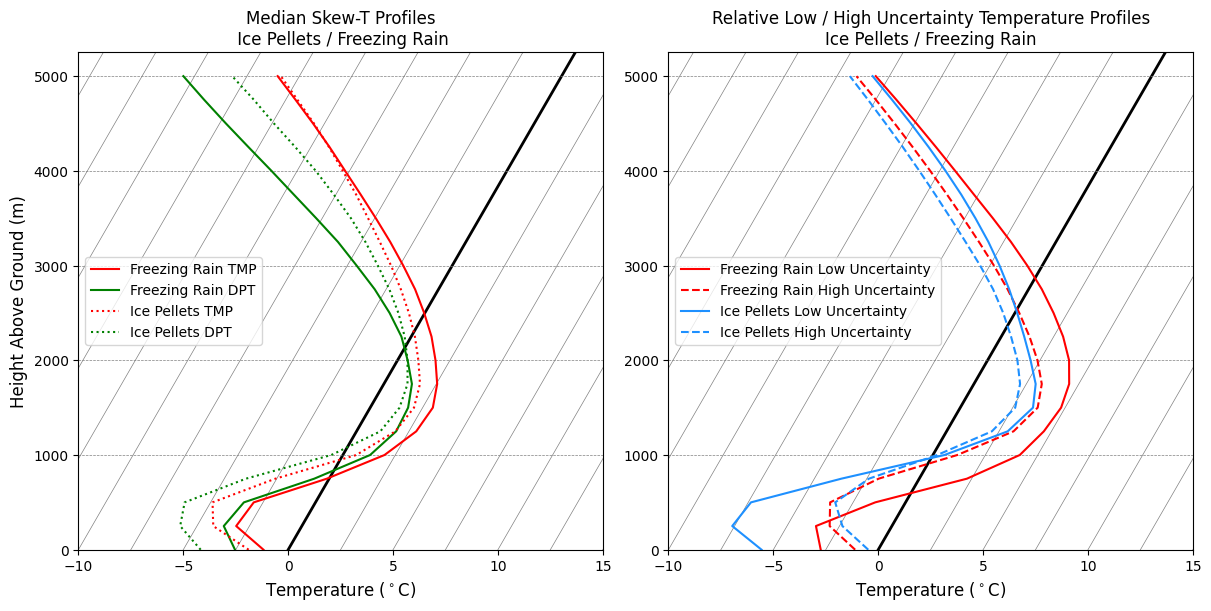

In [13]:
# Figure setup
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
sfig = fig.subfigures(1, 1)
axs = [sfig.add_subplot(1, 2, i+1, projection='skewx', rotation=30) for i in range(2)]
temp_range = np.arange(-30, 17.5, 2.5)


for i, ax in enumerate(axs):
    h = vertical_atm
    if i == 0:
        t_frzr = t_comp_preds.loc[3].values
        td_frzr = d_comp_preds.loc[3].values
        t_icep = t_comp_preds.loc[2].values
        td_icep = d_comp_preds.loc[2].values
    # # Plot data
        ax.plot(t_frzr, h, color='red', linestyle='-', label='Freezing Rain TMP')
        ax.plot(td_frzr, h, color='green', linestyle='-', label='Freezing Rain DPT')
        ax.plot(t_icep, h, color='red', linestyle='dotted', label='Ice Pellets TMP')
        ax.plot(td_icep, h, color='green', linestyle='dotted', label='Ice Pellets DPT')
        ax.legend(loc='center left')
        ax.set_title('Median Skew-T Profiles\n Ice Pellets / Freezing Rain')
        ax.set_ylabel('Height Above Ground (m)', fontsize=12)
        ax.set_xlabel('Temperature ($^\circ$C)', fontsize=12)

    if i == 1:

        t_frzr = f10[temps].mean().values
        td_frzr = f90[temps].mean().values
        t_icep = pl10[temps].mean().values
        td_icep = pl90[temps].mean().values
    # # Plot data
        ax.plot(t_frzr, h, color='red', linestyle='-', label='Freezing Rain Low Uncertainty')
        ax.plot(td_frzr, h, color='red', linestyle='--', label='Freezing Rain High Uncertainty')
        ax.plot(t_icep, h, color='dodgerblue', linestyle='-', label='Ice Pellets Low Uncertainty')
        ax.plot(td_icep, h, color='dodgerblue', linestyle='--', label='Ice Pellets High Uncertainty')
        ax.legend(loc='center left')
        ax.set_title('Relative Low / High Uncertainty Temperature Profiles\nIce Pellets / Freezing Rain') 
        # ax.set_ylabel('Height Above Ground (m)', fontsize=12)
        ax.set_xlabel('Temperature ($^\circ$C)', fontsize=12)

    # Axis limits and basic y-grid
    ax.set_ylim(0, 5250)
    ax.set_xlim(-10, 15)
    ax.grid(True, axis='y', color='gray', linestyle='--', linewidth=0.5)

    # Add skewed isotherms
    for temp in temp_range:
        color = 'black' if temp == 0 else 'grey'
        lw = 2 if temp == 0 else 0.5
        ax.plot(
            [temp, temp],
            [-10, 15],
            transform=ax.get_xaxis_transform(which='grid'),
            color=color,
            linewidth=lw,
            linestyle='-',
            zorder=-1
        )
plt.savefig("/glade/derecho/scratch/cbecker/ptype_paper/figures/composite_FRZR_ICEP_UQ.png", dpi=300, bbox_inches="tight")

In [14]:
def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
                        xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1),
                        dpi=300, csi_cmap="Greys",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5), label_fontsize=14,
                        title_fontsize=16, tick_fontsize=12):
    """
    Draws a performance diagram from a set of DistributedROC objects.

    A performance diagram is a variation on the ROC curve in which the Probability of False Detection on the
    x-axis has been replaced with the Success Ratio (1-False Alarm Ratio or Precision). The diagram also shows
    the Critical Success Index (CSI or Threat Score) as a series of curved contours, and the frequency bias as
    angled diagonal lines. Points along the 1:1 diagonal are unbiased, and better performing models should appear
    in the upper right corner. The performance diagram is particularly useful for displaying verification for
    severe weather warnings as it displays all three commonly used statistics (POD, FAR, and CSI) simultaneously
    on the same chart.

    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels: list or array of labels describing each DistributedROC object.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        csi_cmap (str): Matplotlib colormap used to fill CSI contours.
        csi_label (str): Label for CSI colormap.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles.
        label_fontsize (int): Font size of the x and y axis labels.
        title_fontsize (int): Font size of the title.
        tick_fontsize (int): Font size of the x and y tick labels.

    Examples:

        >>> from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> performance_diagram([roc], ["Random"], ["orange"], ["o"], "random_performance.png")
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    fig, ax = plt.subplots(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7)])
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            perf_curves = np.dstack([b_roc.performance_curve().values for b_roc in b_set])
            pod_range = np.nanpercentile(perf_curves[:, 0], ci, axis=1)
            sr_range = np.nanpercentile(1 - perf_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            sr_poly[np.isnan(sr_poly)] = 1
            plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.scatter(1 - perf_data["FAR"], perf_data["POD"], s=100, marker=markers[r], color=colors[r], edgecolor='k', alpha=0.8)
    mod1 = ax.scatter([0], [0], s=60, label='RAP', color='k', marker='v')
    mod2 = ax.scatter([0], [0], s=60, label='Area\nMethod', color='k', marker='s')
    mod3 = ax.scatter([0], [0], s=60, label='Modified Area\nMethod', color='k', marker='P')
    mod4 = ax.scatter([0], [0], s=60, label='ML', color='k', marker='o')

    x, y = 0.71, 0.36   # example if using Axes coords
    line_height = 0.035  # vertical spacing in Axes coords

    box_width  = 0.27
    box_height = 0.11
    
    # Draw the background box
    box = FancyBboxPatch(
        (0.71, 0.23),   # box origin is lower-left, so shift down
        box_width, box_height,
        boxstyle="round,pad=0.01",
        fc="white",
        ec="black",
        transform=ax.transAxes,
        zorder=2
    )
    ax.add_patch(box)
    
    labels = [
        ("Rain: Green",    "green"),
        ("Snow: Blue",     "blue"),
        ("Ice Pellets: Purple", "purple"),
        ("Freezing Rain: Red",    "red"),
    ]
    
    line_height = box_height / (len(labels) + 1)
    line_height = 0.03  # vertical spacing in Axes coords
    
    for i, (txt, color) in enumerate(labels):
        ax.text(
            x,
            y - (i + 1) * line_height,
            txt,
            transform=ax.transAxes,
            color=color,
            ha="left",
            va="center",
            fontsize=10,
            zorder=3
        )

    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label, fontsize=12)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(ticks, fontsize=tick_fontsize)
    plt.yticks(ticks, fontsize=tick_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    # plt.close()

In [15]:
val_w_analysis = pd.read_parquet('/glade/derecho/scratch/cbecker/ptype_data/analysis_data.parquet')
df_sub = val_w_analysis[val_w_analysis['cprecip'] == 1]
df_sub = df_sub.rename(columns={'modified_area_prob_RN_softmax': 'modified_area_RN_prob',
 'modified_area_prob_SN_softmax': 'modified_area_SN_prob',
 'modified_area_prob_ICEP_softmax': 'modified_area_ICEP_prob',
 'modified_area_prob_FZRA_softmax':  'modified_area_FZRA_prob',
                  'ML_prob_RN': 'ML_RN_prob',
                  'ML_prob_SN': 'ML_SN_prob',
                  'ML_prob_ICEP': 'ML_ICEP_prob',
                  'ML_prob_FZRA': 'ML_FZRA_prob', 
                               'pred': 'ML_pred'})
mPING = df_sub["mPING"].values

/glade/derecho/scratch/cbecker/tmp/ipykernel_70297/2120563268.py:57: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_70297/2120563268.py:57: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_70297/2120563268.py:58: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


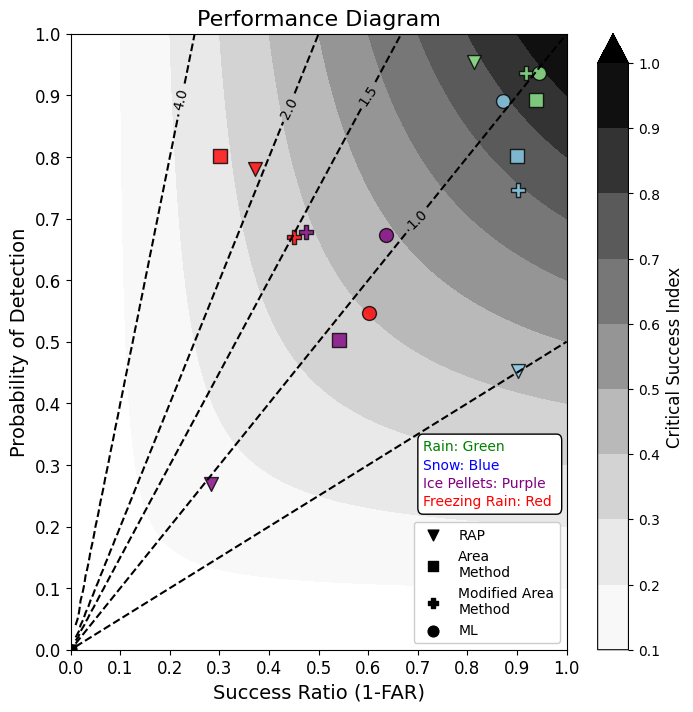

In [20]:
plt.rcParams['text.usetex'] = False
rocs = []
labels = ['RAP', None, None, None, 'Area', None, None, None, 'Modified\nArea', None, None, None, 'ML', None, None, None]
colors = ["lightgreen", "skyblue", "purple", "red"] * 4
markers = ['v'] * 4 + ['s'] * 4 + ['P'] * 4 + ['o'] * 4 
mPING = df_sub["mPING"].values
for model in ['rap_pred', 'area_pred', 'modified_area_pred', 'ML_pred']: 
    for i in range(4):
        class_ptype = i
        preds = df_sub[model].values
        obs = np.where(mPING == class_ptype, 1, 0)
        forecasts = np.where(preds == class_ptype, 1, 0) 
        roc = DistributedROC(thresholds=np.array([0.5]))
        roc.update(forecasts, obs)
        rocs.append(roc)
performance_diagram(rocs, labels, colors, markers, "/glade/derecho/scratch/cbecker/ptype_paper/figures/ptype_performance_diagram.png")

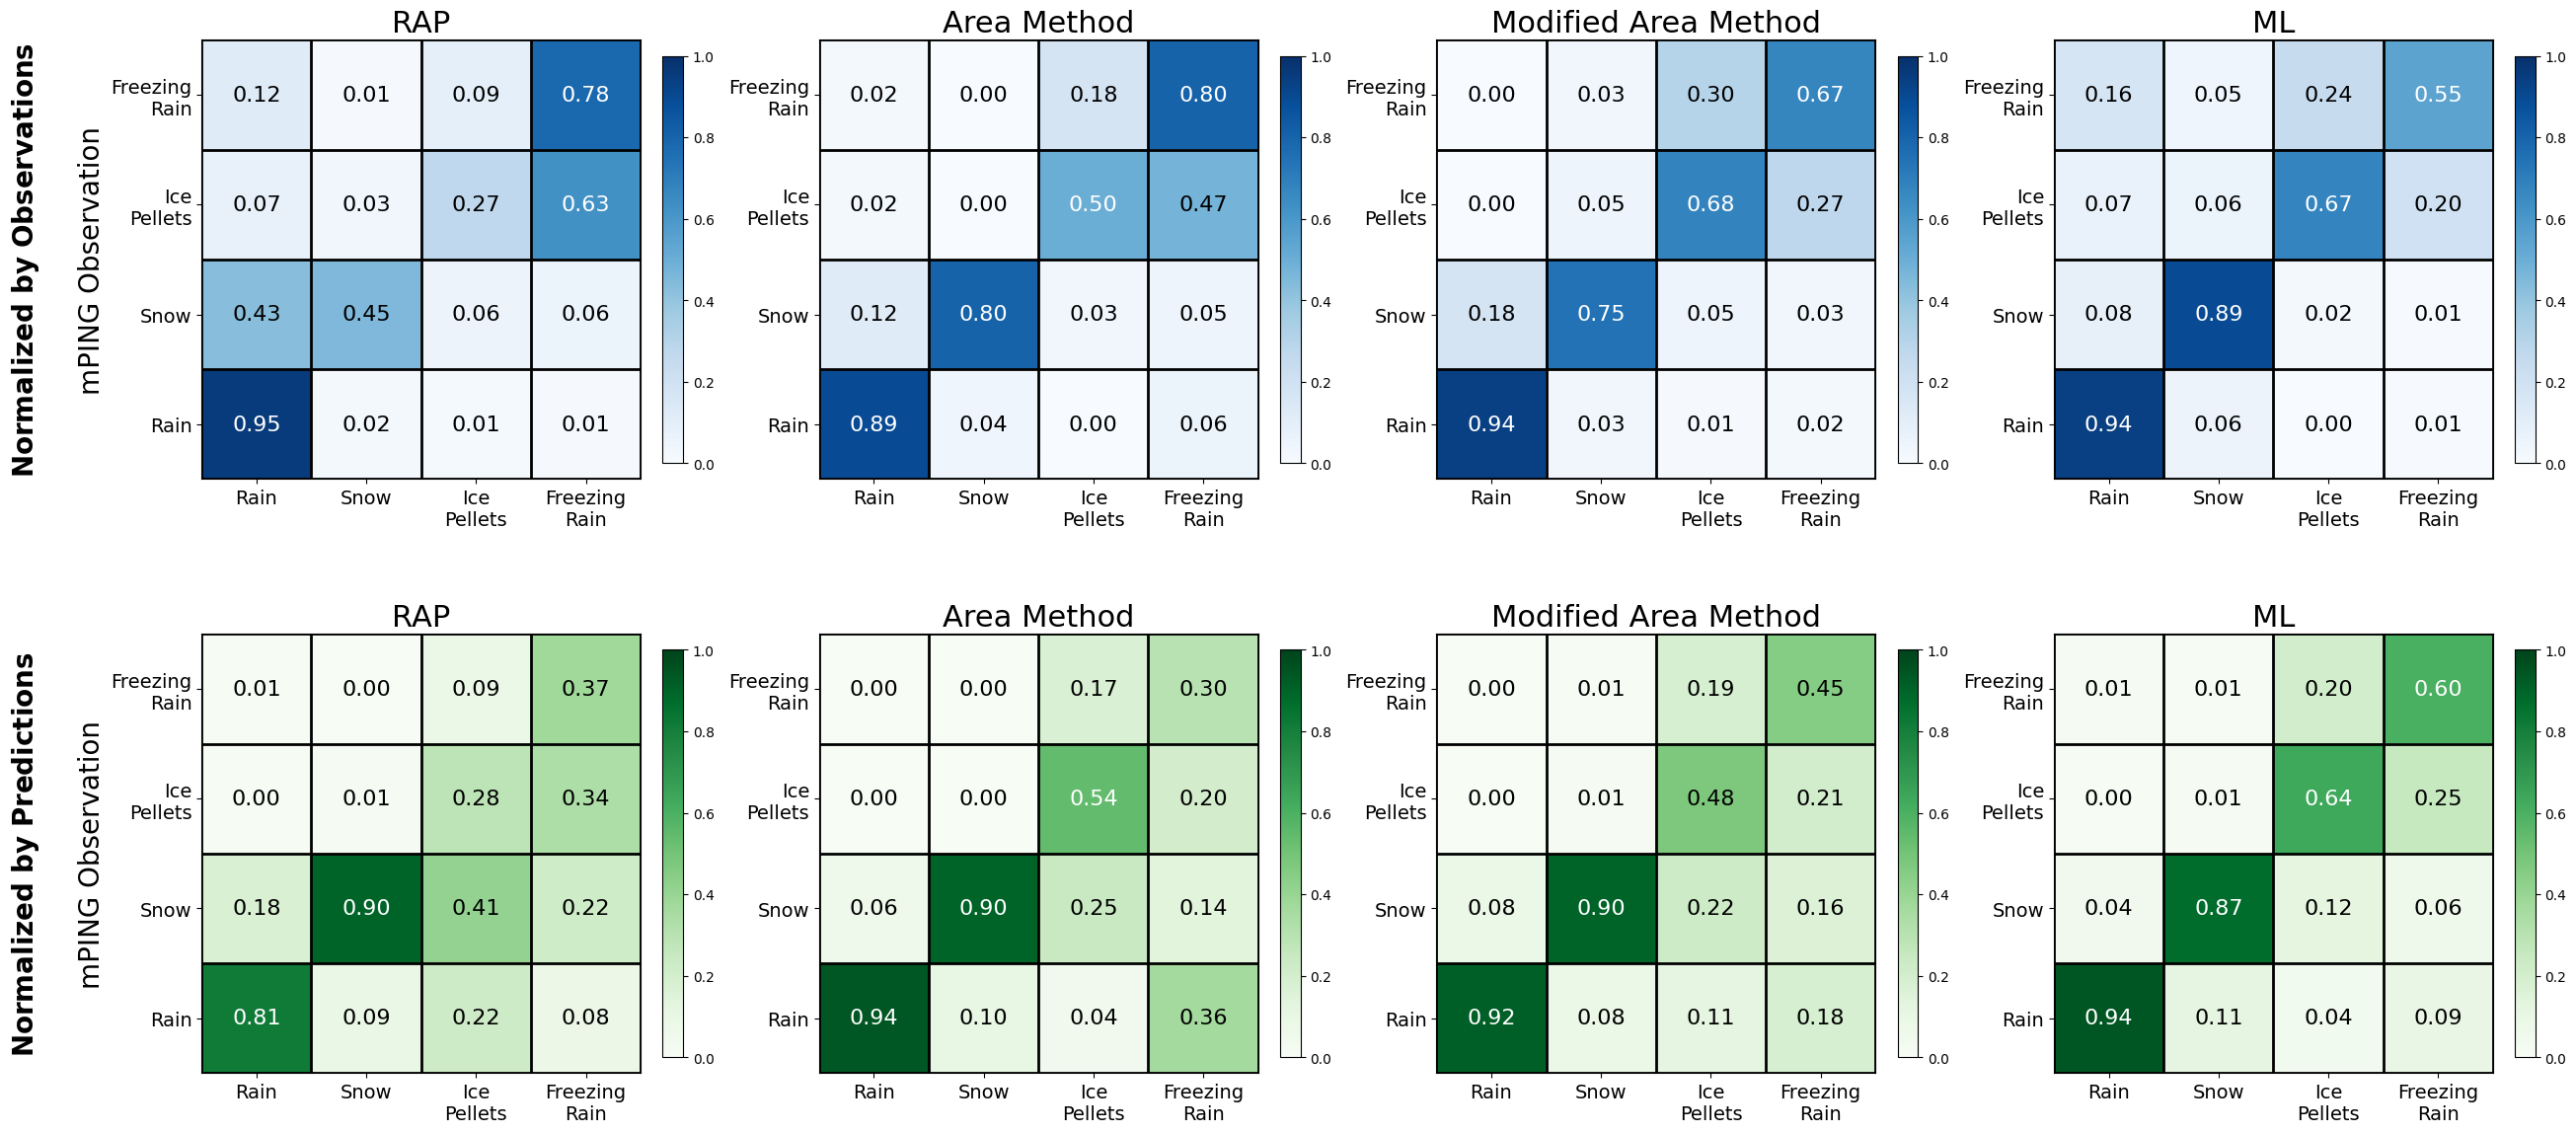

In [17]:
obs = df_sub['mPING']
preds = [df_sub['rap_pred'], df_sub['area_pred'], df_sub['modified_area_pred'], df_sub['ML_pred'], df_sub['rap_pred'], df_sub['area_pred'], df_sub['modified_area_pred'], df_sub['ML_pred']]
normalize = ['true', 'true', 'true', 'true', 'pred', 'pred', 'pred', 'pred']
# normalize = [None] * 8
pred_name = ['RAP', 'Area Method', 'Modified Area Method', 'ML', 'RAP', 'Area Method', 'Modified Area Method', 'ML']
cms = []

classes = ['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']
fig, axes = plt.subplots(2, 4, figsize=(26,12), constrained_layout=True)
for k, ax in enumerate(axes.ravel()):
    
    ax.set_xticks(range(len(classes)), classes, fontsize=14)
    ax.set_yticks(range(len(classes)), classes, fontsize=14)
    
    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(classes), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(classes), 1), minor=True)
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    
    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)
    
    ax.set_xticks(range(len(classes)), classes, fontsize=14)
    ax.set_yticks(range(len(classes)), classes, fontsize=14)
    
    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(classes), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(classes), 1), minor=True)
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    
    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)
    
    cm = confusion_matrix(obs, preds[k], normalize=normalize[k])
    cms.append(cm)
    if normalize[k] == 'true':
        values = cm / cm.sum(axis=1)
    elif normalize[k] =='pred':
        values = cm / cm.sum(axis=0)
    else:
        values=cm

    if k < 4:
        cmap = "Blues"
    else:
        cmap='Greens'
    im = ax.imshow(values, cmap=cmap, vmin=0, vmax=1)
    ax.invert_yaxis()
    
    cb = plt.colorbar(im, ax=ax, shrink=0.7)
    
    for i in range(4):
        for j in range(4):
            color='k' if values[i,j] < 0.5 else 'white'
            a = f'{values[i,j]:.2f}'
            ax.annotate(a, (j, i), 
                        color=color, va='center', ha='center', fontsize=16)
    if (k == 0):        
        ax.set_ylabel('$\\bf{Normalized}$ $\\bf{by}$ $\\bf{Observations}$\n\nmPING Observation', fontsize=20)
    if (k == 4):        
        ax.set_ylabel('$\\bf{Normalized}$ $\\bf{by}$ $\\bf{Predictions}$\n\nmPING Observation', fontsize=20)
    if k < 10:
        ax.set_title(pred_name[k], fontsize=22)
plt.savefig("/glade/derecho/scratch/cbecker/ptype_paper/figures/all_cm_new.png", dpi=300, bbox_inches='tight')

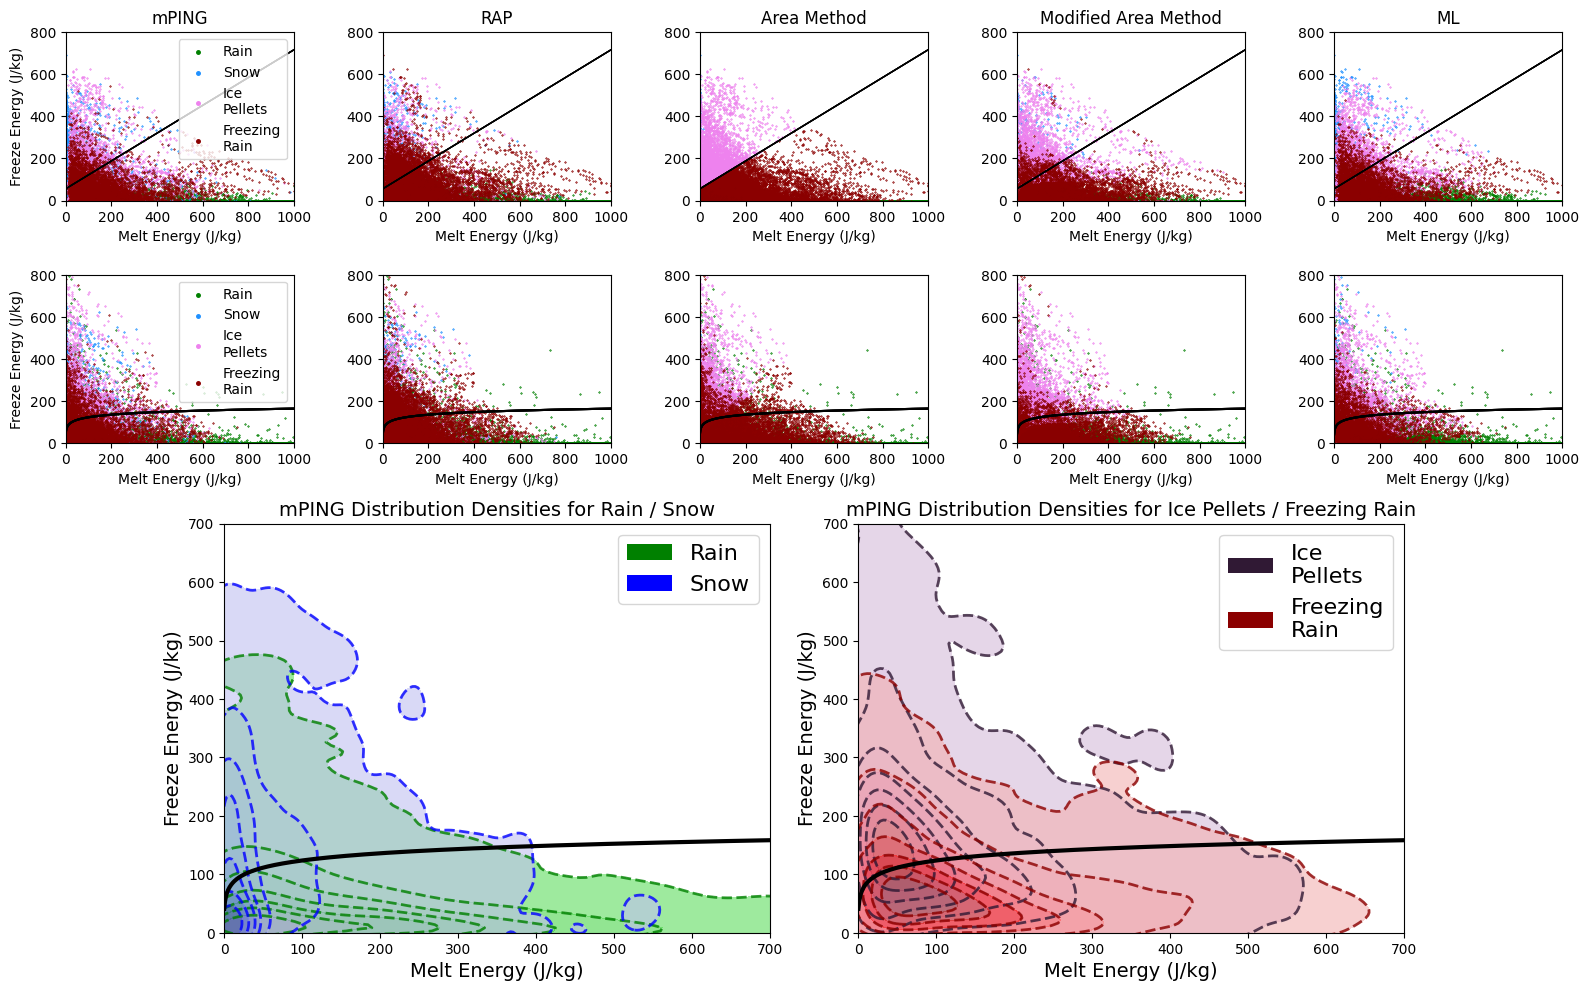

In [21]:
plt.rcParams['text.usetex'] = False  # requires LaTeX installed

colors = ['green', 'dodgerblue', 'violet', 'darkred']
ptypes = ['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']
ds_type = ['mPING', 'rap_pred', 'area_pred', 'modified_area_pred', 'ML_pred']
titles = ["mPING", "RAP", "Area Method", "Modified Area Method", "ML"]

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 10, height_ratios=[1, 1, 2.5], )  # 2 rows, 10 columns

top_axes = [fig.add_subplot(gs[0, i*2:(i+1)*2]) for i in range(5)]
mid_axes = [fig.add_subplot(gs[1, i*2:(i+1)*2]) for i in range(5)]
for i in range(5):
    for j, p in enumerate(ptypes):
        data = df_sub[df_sub[ds_type[i]] == j]
        top_axes[i].scatter(data['P_Area (J/kg)__T'], np.abs(data['N_Area (J/kg)__T']), s=0.1, color=colors[j], label=ptypes[j])
        top_axes[i].set_xlim(0, 1000)
        top_axes[i].set_ylim(0, 800)
        top_axes[i].set_title(titles[i])
        top_axes[i].plot(56 + (np.arange(0, 1000) * 0.66), color='k', linewidth=1)
        if i == 0:
            top_axes[i].legend(loc="upper right", markerscale=8, fontsize=10)

        mid_axes[i].scatter(data['P_Area (J/kg)__WB'], np.abs(data['N_Area (J/kg)__WB']), s=0.1, color=colors[j], label=ptypes[j])
        mid_axes[i].set_xlim(0, 1000)
        mid_axes[i].set_ylim(0, 800)
        # mid_axes[i].set_title(titles[i])
        mid_axes[i].plot(41 + (17.9 * np.log(np.arange(0, 1000) + 1)), color='k')
        if i == 0:
            mid_axes[i].legend(loc="upper right", markerscale=8, fontsize=10)
        if i == 0:

            top_axes[i].set_ylabel("Freeze Energy (J/kg)", fontsize=10)
            mid_axes[i].set_ylabel("Freeze Energy (J/kg)", fontsize=10)
        top_axes[i].set_xlabel("Melt Energy (J/kg)", fontsize=10)
        mid_axes[i].set_xlabel("Melt Energy (J/kg)", fontsize=10)

bottom_left = fig.add_subplot(gs[2, 1:5])
bottom_right = fig.add_subplot(gs[2, 5:9])

bottom_left.set_aspect(aspect=0.75)
bottom_right.set_aspect(aspect=0.75, adjustable='box')



profile_type = 'WB'
model = 'mPING'
colors = ['green', 'blue', '#301934', 'darkred']


data = df_sub[(df_sub[f'{model}'] == 0) & (df_sub[f'P_Area (J/kg)__{profile_type}'] > 0) &  (df_sub[f'N_Area (J/kg)__{profile_type}'] < 0)]
data.loc[:, f'N_Area (J/kg)__{profile_type}'] = np.abs(data[f'N_Area (J/kg)__{profile_type}'].values)
sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), color=colors[0], fill=True, alpha=0.6, common_norm=True, ax=bottom_left)
sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), linestyles='--', linewidths=2, color=colors[0], fill=False, alpha=0.8, common_norm=True, ax=bottom_left,label='Rain')

data = df_sub[(df_sub[f'{model}'] == 1) & (df_sub[f'P_Area (J/kg)__{profile_type}'] > 0) &  (df_sub[f'N_Area (J/kg)__{profile_type}'] < 0)]
data.loc[:, f'N_Area (J/kg)__{profile_type}'] = np.abs(data[f'N_Area (J/kg)__{profile_type}'].values)
sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), color=colors[1], fill=True, alpha=0.6, common_norm=True, ax=bottom_left)
sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), linestyles='--', linewidths=2, color=colors[1], fill=False, alpha=0.8, common_norm=True, ax=bottom_left, label="Snow")


data = df_sub[(df_sub[f'{model}'] == 2) & (df_sub[f'P_Area (J/kg)__{profile_type}'] > 0) &  (df_sub[f'N_Area (J/kg)__{profile_type}'] < 0)]
data.loc[:, f'N_Area (J/kg)__{profile_type}'] = np.abs(data[f'N_Area (J/kg)__{profile_type}'].values)
sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), color=colors[2], fill=True, alpha=0.6, common_norm=True, ax=bottom_right)
br = sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), linestyles='--', linewidths=2, color=colors[2], fill=False, alpha=0.8, common_norm=True, ax=bottom_right, label="Ice\nPellets")

data = df_sub[(df_sub[f'{model}'] == 3) & (df_sub[f'P_Area (J/kg)__{profile_type}'] > 0) &  (df_sub[f'N_Area (J/kg)__{profile_type}'] < 0)]
data.loc[:, f'N_Area (J/kg)__{profile_type}'] = np.abs(data[f'N_Area (J/kg)__{profile_type}'].values)
sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), color=colors[3], fill=True, alpha=0.6, common_norm=True, ax=bottom_right)
bl = sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), linestyles='--', linewidths=2, color=colors[3], fill=False, alpha=0.8, common_norm=True, ax=bottom_right, label="Freezing\nRain")
# data = data.loc[:, f'N_Area (J/kg)__{profile_type}'] = np.abs(data[f'N_Area (J/kg)__{profile_type}'].values)

handles_left = [mpatches.Patch(facecolor="green", label="Rain"),
           mpatches.Patch(facecolor="blue", label='Snow')]
handles_right = [mpatches.Patch(facecolor='#301934', label="Ice\nPellets"),
           mpatches.Patch(facecolor="darkred", label='Freezing\nRain')]
bottom_left.legend(handles=handles_left, fontsize=16)
bottom_right.legend(handles=handles_right, fontsize=16)
bottom_left.set_ylim(0, 700)
bottom_left.set_xlim(0, 700) 
bottom_right.set_ylim(0, 700)
bottom_right.set_xlim(0, 700)
bottom_left.set_xlabel("Melt Energy (J/kg)", fontsize=14)
bottom_right.set_xlabel("Melt Energy (J/kg)", fontsize=14)
bottom_left.set_ylabel("Freeze Energy (J/kg)", fontsize=14)
bottom_right.set_ylabel("Freeze Energy (J/kg)", fontsize=14)
# sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), color=colors[i], fill=True, alpha=0.6, common_norm=False)
# sns.kdeplot(data=data, x=f'P_Area (J/kg)__{profile_type}', y=f'N_Area (J/kg)__{profile_type}', levels=np.linspace(0.02, 1, 8), linestyles='--', linewidths=2, color=colors[i], fill=False, alpha=0.8, common_norm=False)

bottom_left.plot(41 + (17.9 * np.log(np.arange(0, 700) + 1)), color='k', linestyle='-', linewidth=3, label="_nolegend_")
bottom_right.plot(41 + (17.9 * np.log(np.arange(0, 700) + 1)), color='k', linestyle='-', linewidth=3, label="_nolegend_")

# # Titles
# for i, ax in enumerate(top_axes):
#     ax.set_title(f"Top {i+1}")
bottom_left.set_title("mPING Distribution Densities for Rain / Snow", fontsize=14)
bottom_right.set_title("mPING Distribution Densities for Ice Pellets / Freezing Rain", fontsize=14)
# bottom_left.legend()
# bottom_right.legend()
plt.tight_layout()
plt.savefig('/glade/derecho/scratch/cbecker/ptype_paper/figures/scatter_kde.png', dpi=300, bbox_inches='tight')
# plt.show()

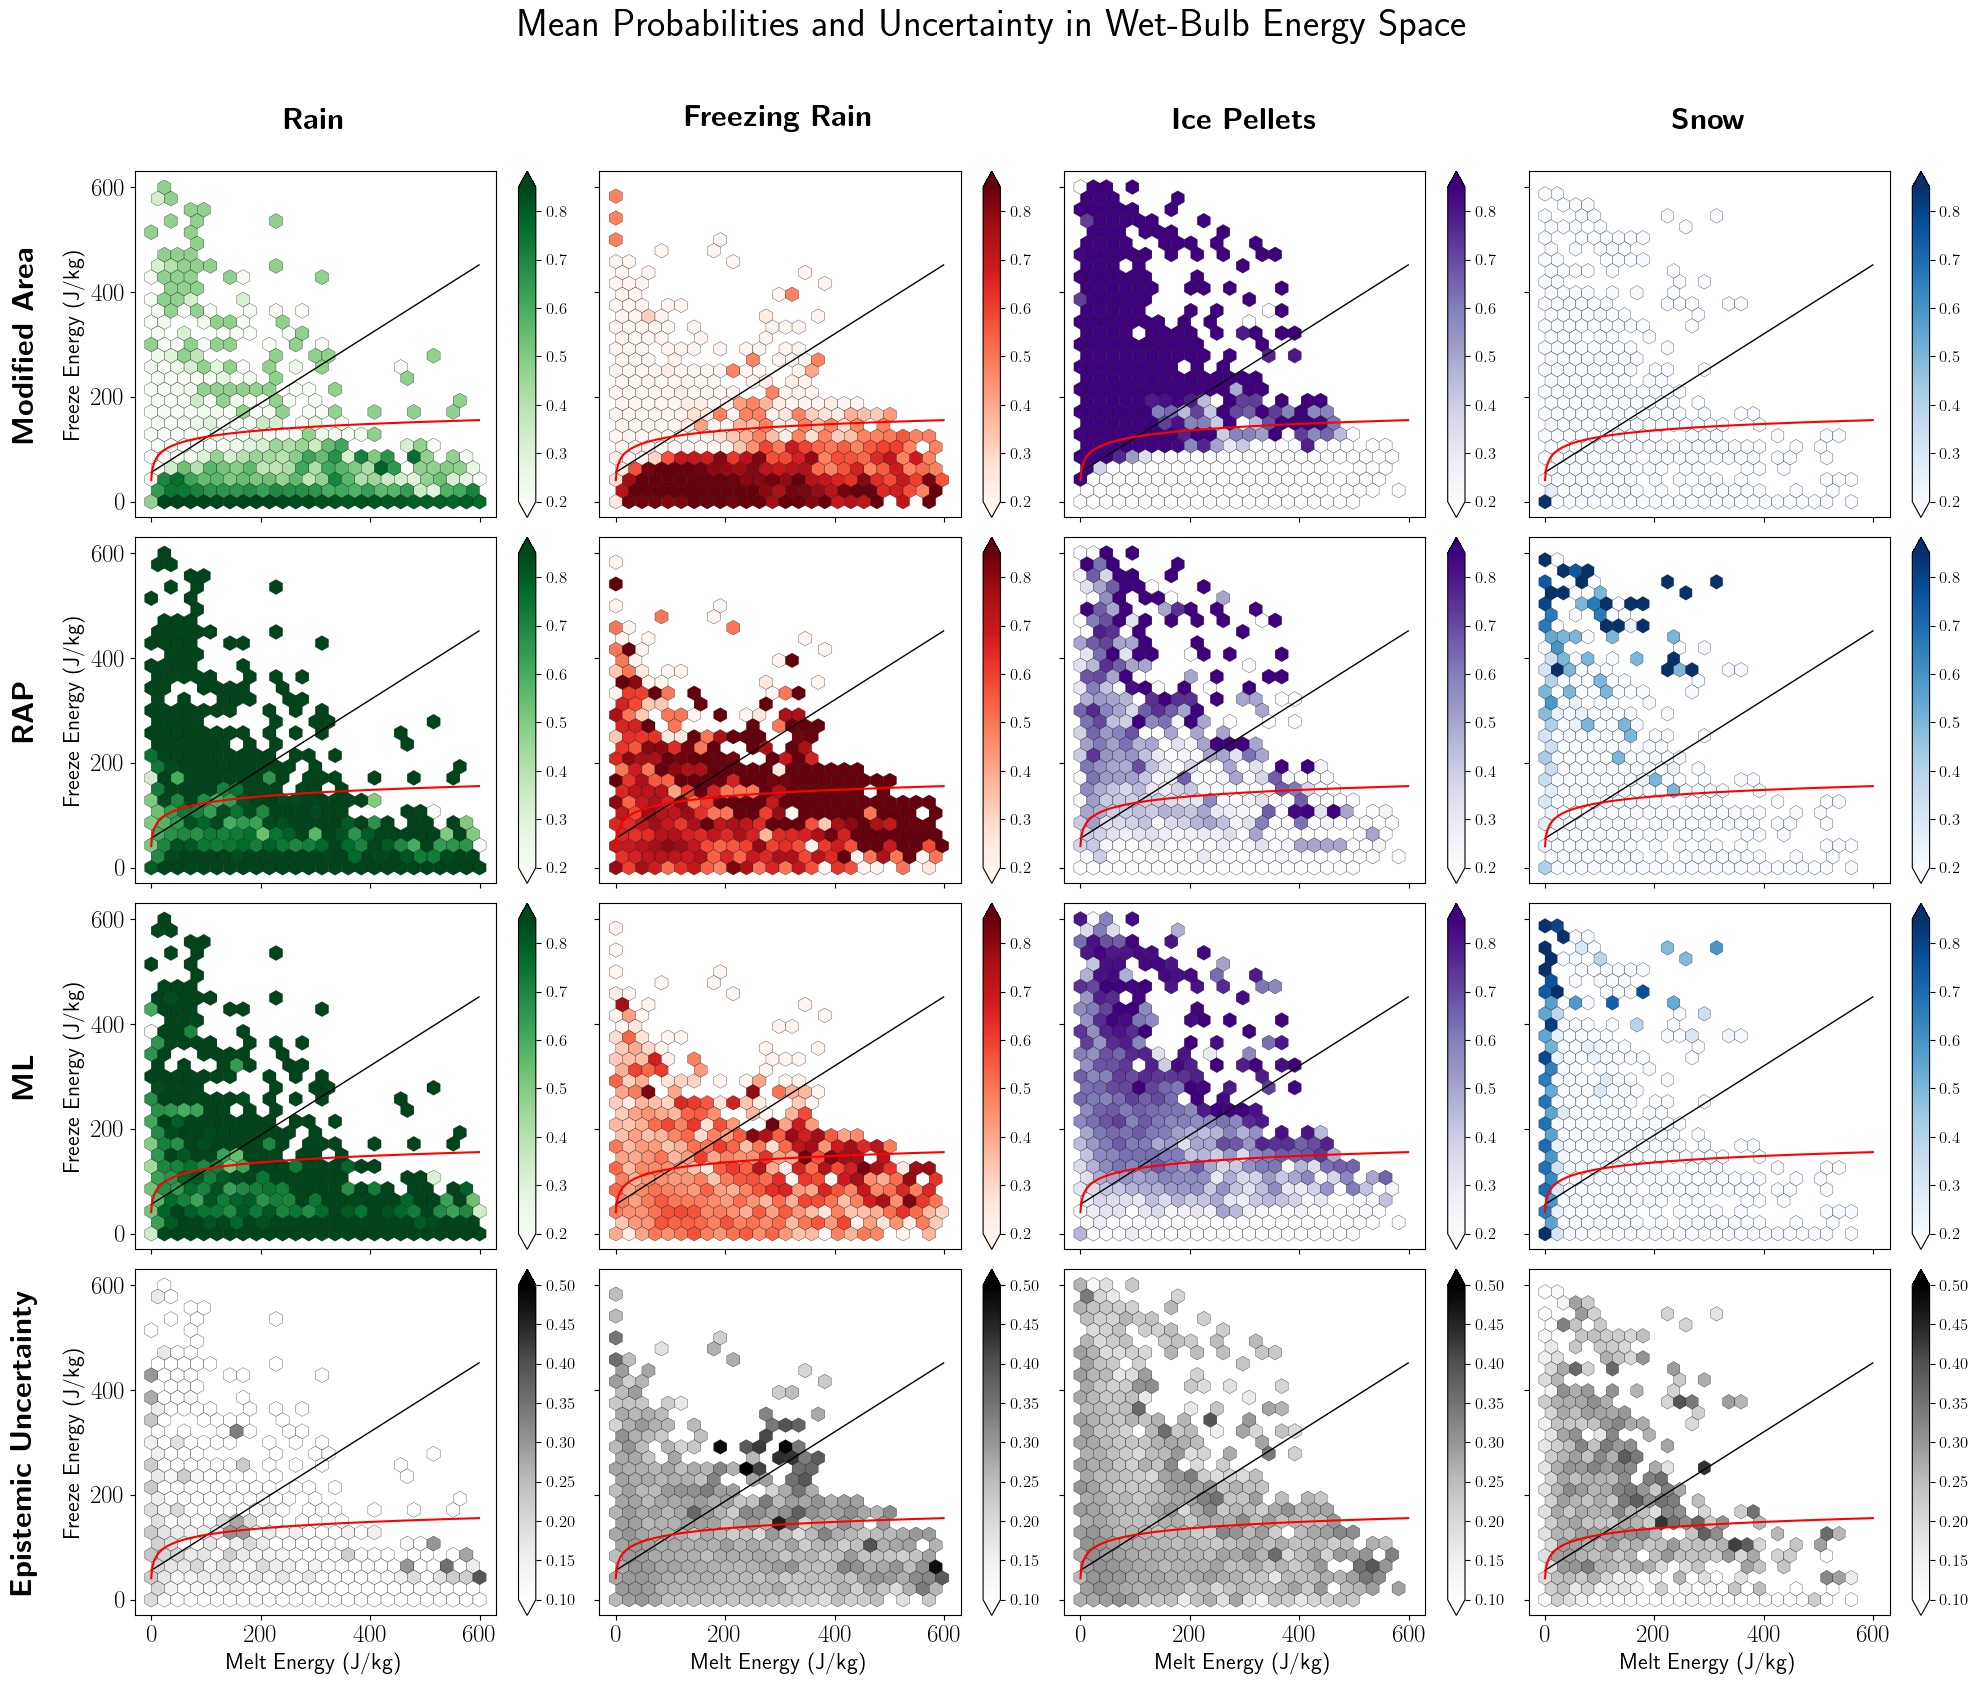

In [57]:
plt.rcParams['text.usetex'] = True  # requires LaTeX installed
models = ['modified_area', 'RAP', 'ML', '']
cmaps = ["Greens", "Reds", "Purples", "Blues"]
ptype_order = [0, 3, 2, 1]
profile_type = 'WB'
y_titles = [r'\fontsize{22}{22}\selectfont\textbf{Modified Area}' + '\n\n', r'\fontsize{22}{22}\selectfont\textbf{RAP}' + '\n\n', r'\fontsize{22}{22}\selectfont\textbf{ML}' + '\n\n', r'\fontsize{22}{22}\selectfont\textbf{Epistemic Uncertainty}' + '\n\n']
titles_3 = [r'\fontsize{22}{22}\selectfont\textbf{Rain}' + '\n\n', r'\fontsize{22}{22}\selectfont\textbf{Freezing Rain}' + '\n\n', r'\fontsize{22}{22}\selectfont\textbf{Ice Pellets}' + '\n\n', r'\fontsize{22}{22}\selectfont\textbf{Snow}' + '\n\n']
fig, axes = plt.subplots(4, 4, figsize=(20, 16), sharex=True, sharey=True)
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=18)
for j in range(4):
    model = models[j]
    probs = [f'{model}_RN_prob', f'{model}_FZRA_prob', f'{model}_ICEP_prob', f'{model}_SN_prob']
    for i in range(4):
        data = df_sub[(df_sub['mPING'] == ptype_order[i]) & (df_sub[f'P_Area (J/kg)__{profile_type}'] <= 600) & (df_sub[f'N_Area (J/kg)__{profile_type}'] >= -600)]
        # data = df_sub[(df_sub['P_Area (J/kg)__WB'] <= 600) & (df_sub['N_Area (J/kg)__WB'] >= -600)]

        if j < 3:
            # data_column = 'max_prob'
            data_column = probs[i]
            cmap = cmaps[i]
            vmin = 0.2
            vmax = 0.85
        else:
            data_column = 'epi_total'
            cmap = "Greys"
            vmin = 0.1 
            vmax = 0.5
        data.loc[:, f'N_Area (J/kg)__{profile_type}'] = np.abs(data[f'N_Area (J/kg)__{profile_type}'].values)
        axes[j, i].plot(56 + (np.arange(0, 600) * 0.66), color='k', linewidth=1)
        axes[j, i].plot(41 + (17.9 * np.log(np.arange(0, 600) + 1)), color='r')
        if j == 0:
            axes[j, i].set_title(f'{titles_3[i]}')
            
        # else:
        #     axes[j, i].set_title(titles_1[i], fontsize=14)
        if i == 0:
            axes[j, i].set_ylabel(f'{y_titles[j]}Freeze Energy (J/kg)', fontsize=16)
        if j == 3:
            axes[j, i].set_xlabel('Melt Energy (J/kg)', fontsize=16)
        
        p = axes[j, i].hexbin(data[f'P_Area (J/kg)__{profile_type}'], data[f'N_Area (J/kg)__{profile_type}'], gridsize=25, C=data[data_column], reduce_C_function=np.mean, edgecolors='k', linewidths=0.2, cmap=cmap, vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(p, extend='both', ax=axes[j, i])
        cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.suptitle("Mean Probabilities and Uncertainty in Wet-Bulb Energy Space", fontsize=28, y=1.05)
plt.savefig('/glade/derecho/scratch/cbecker/ptype_paper/figures/hexbin_all_WB.png', dpi=300, bbox_inches='tight')

In [26]:
def add_zero_crossings(profile, heights):
    
    pre_crossing_level = np.argwhere((np.diff(np.sign(profile)) != 0)*1).flatten()
    post_crossing_level = pre_crossing_level + 1
    indices = []
    crossings_m = []
    for pre, post in zip(pre_crossing_level, post_crossing_level):
        xp = profile[pre:post+1]
        fp = heights[pre:post+1]
        if xp[0] > xp[1]:
            xp = xp[::-1]
            fp = fp[::-1]
        crossings_m.append(np.interp(0, xp, fp))
        indices.append(post)
    profile = np.insert(profile, indices, 0)
    heights = np.insert(heights, indices, crossings_m)

    return profile, heights


def calc_sounding_stats(profile, heights):

    FREEZING_K = 273.15
    GRAVITY = 9.81 

    cold_area, warm_area = [], []
    low_i, cold_thickness, warm_thickness = 0, 0, 0
    profile, heights = add_zero_crossings(profile, heights)
    surface = profile[0]
    try:
        upper_bound_index = np.argwhere(profile==0).max() + 1 # get index of highest crossing where we no longer care about
        lower_bound_index = np.argwhere(profile==0).min()
        highest_crossing = heights[upper_bound_index - 1]
        lowest_crossing = heights[lower_bound_index]
    except:
        min_cold, max_warm, t_span, highest_crossing, lowest_crossing = np.nan, np.nan, np.nan, np.nan, np.nan
        metrics = dict(cold_area=np.sum(cold_area),
                       warm_area=np.sum(warm_area),
                       cold_thickness=cold_thickness,
                       warm_thickness=warm_thickness,
                       min_cold=min_cold, 
                       max_warm=max_warm, 
                       highest_crossing=highest_crossing,
                       lowest_crossing=lowest_crossing, 
                       surface=surface)
        return [np.sum(cold_area), np.sum(warm_area), cold_thickness, warm_thickness, min_cold, max_warm, highest_crossing, lowest_crossing, surface]
    
    min_cold = profile[:upper_bound_index].min()
    max_warm = profile[:upper_bound_index].max()
    for i in range(upper_bound_index):
        if (profile[i] == 0):

            energy = np.trapezoid(GRAVITY * (profile[low_i:i+1]/FREEZING_K) , heights[low_i:i+1])
            if energy <= 0:
                cold_area.append(energy)
                cold_thickness += heights[i] - heights[low_i]
            else:
                warm_area.append(energy)
                warm_thickness += heights[i] - heights[low_i]
            low_i = i
    return [np.sum(cold_area), np.sum(warm_area), cold_thickness, warm_thickness, min_cold, max_warm, highest_crossing, lowest_crossing, surface]

def skewCompositeFigAx(figsize=(5, 5), num_subplots=1, rows=1, cols=None):
    # fig ax setup for skewx fig
    # returns top subfigure and a list of axs lists

    if (num_subplots > 1) and (figsize == (5, 5)):
        figsize = (10, 5)
    if cols:  # add blank subplots below
        num_subplots = cols

    fig = plt.figure(figsize=figsize)
    # gs = fig.add_gridspec(nrows=num_subplots + 1, ncols=1)

    sfigs = fig.subfigures(rows, 1)
    if rows == 1:
        sfigs = [sfigs]

    skew_axs = sfigs[0].subplots(
        1, num_subplots, sharey=True, subplot_kw=dict(projection="skewx", rotation=30)
    )
    if num_subplots == 1:
        skew_axs = [skew_axs]

    axs = skew_axs
    if num_subplots == 1:
        axs = [axs]
    if rows > 1:
        t_axs = sfigs[1].subplots(1, num_subplots, sharex=True)
        axs = [skew_axs, t_axs]

    skew_axs[0].set_ylabel("Height above ground (m)", fontsize=10)
    for ax in skew_axs:
        ax.grid(which="both")

        major_ticks = np.arange(-100, 100, 5)
        ax.set_xticks(major_ticks)
        ax.grid(which="major", alpha=0.5)

        # minor_ticks = np.arange(xlowlim - 60, xhighlim, 1)
        # ax.set_xticks(minor_ticks, minor=True)
        # ax.grid(which='minor', alpha=0.2)

        ax.axvline(x=0, ymin=0, ymax=1, c="k")
        ax.set_ylim(-100, 5100)
        ax.set_xlim(-10, 15)
    if rows == 1:
        axs = skew_axs
    return fig, sfigs[0], axs

def fetch(station_id, start_date, end_date, data_vars=["tmpc", "dwpc", "wxcodes"], report_type=[1], str_format="%Y%m%d %H00", subsample=False, freq="15min"):
    """Download data we are interested in!"""

    start = pd.to_datetime(start_date)
    data = '&'.join([f"data={str(dv)}" for dv in data_vars])
    report_types = '&'.join([f"report_type={str(rt)}" for rt in report_type])
    end = pd.to_datetime(end_date) + pd.Timedelta(days=1)
    uri = ("http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"
           f"station={station_id}&{data}&year1={start.year}&month1={start.month}&day1={start.day}&"
           f"year2={end.year}&month2={end.month}&day2={end.day}&"
           "tz=Etc%2FUTC&format=onlycomma&latlon=yes&elev=yes&missing=M&trace=T&"
           f"direct=yes&{report_types}")

    data = convert_codes(pd.read_csv(uri))
    data['valid'] = data['valid'].astype('datetime64[ns]')
    data = data.set_index('valid')
    data = data.loc[(data.index >= start) & (data.index <= end)]
    if subsample:
        return subsample_time(data, freq=freq)
    else:
        return data

def convert_codes(data):

    ptype_conv = {'M': 'No Precip', 'BR': 'Mist', 'RA': 'Rain', 'SN': 'Snow', 'UP': 'Unidentified', 'FZRA': 'FZRA', 'FZFG': 'FZFG'}
    color_map = {"Rain": "green", "Snow": "blue", "FZRA": "red", "Unidentified": "orange", "No Precip": "white", "Mist": "grey"}
    for k, v in ptype_conv.items():
        data.loc[data['wxcodes'].str.contains(k), 'new_codes'] = v
    data['color_code'] = data['new_codes'].map(color_map)

    data['lon'] = data['lon'] % 360
    data["dummy_height"] = 1

    return data

def subsample_time(data, freq='15min'):
    
    resampled_data = data.resample(freq).asfreq()
    resampled_data["color_code"] = resampled_data["color_code"].fillna("grey")
    return resampled_data

def match_latlon(ds, lat, lon, crs='proj=lcc lat_0=38.5 lon_0=262.5 lat_1=38.5 lat_2=38.5 x_0=0 y_0=0 R=6371229 units=m no_defs'):

    p = Proj(crs)
    x_proj_coord, y_proj_coord = p(ds["longitude"].values, ds["latitude"].values)
    coords = np.stack([x_proj_coord.flatten(), y_proj_coord.flatten()], axis=1)
    distance, index = KDTree(coords).query(p(lon, lat))
    x = np.isclose(x_proj_coord[0, :], coords[index, 0], atol=1e-3, rtol=1e-3).nonzero()[0][0]
    y = np.isclose(y_proj_coord[:, 0], coords[index, 1], atol=1e-3, rtol=1e-3).nonzero()[0][0]
    print(x, y)
    return ds.isel(x=x, y=y)

def get_analysis_files(base_path, start, end):

    files = []
    start_date = pd.to_datetime(start)
    for date in pd.date_range(start, end, freq="1h"):
        dt = date - pd.Timedelta(f"1h")
        path = os.path.join(base_path, dt.strftime("%Y%m%d"), dt.strftime("%H%M"), f"MILES_ptype_hrrr_{dt.strftime('%Y-%m-%d_%H00')}_f01.nc")
        files.append(path)

    return files

def get_forecast_files(base_path, init_time, start_fh, end_fh):

    files = []
    init = pd.to_datetime(init_time)
    for fh in range(start_fh, end_fh + 1):
        path = os.path.join(base_path, init.strftime("%Y%m%d"), init.strftime("%H%M"), f"MILES_ptype_hrrr_{init.strftime('%Y-%m-%d_%H00')}_f{fh:02}.nc")
        files.append(path)

    return files

In [27]:
plt.rcParams['text.usetex'] = False
base_path = "/glade/derecho/scratch/cbecker/ptype_real_time/full_central_region/hrrr/"
start = "20231225"
end = "20231227"
files = get_analysis_files(base_path, start, end)
ds = xr.open_dataset(files[22], engine='h5netcdf', decode_timedelta=True).squeeze()

In [28]:
ds = xr.open_dataset('/glade/derecho/scratch/cbecker/HRRR_w_wetbulb_case.nc', engine='h5netcdf', decode_timedelta=True).squeeze()

In [29]:
ptypes = ["rain", "snow", "icep", "frzr"]
cat_vars = ["crain", "csnow", "cicep", "cfrzr"]
hrrr_precip = ds[cat_vars].to_array().squeeze().sum(dim=('variable')).values
precip_mask = np.where(hrrr_precip > 0, 1, 0)
hrrr_mixed = np.where(hrrr_precip > 1, 1, 0)
hrrr_mixed_inv = np.where(hrrr_mixed, 0, 1) 
ds['aleatoric'] = ds[[f"ML_{pt}_ale" for pt in ptypes]].to_array().sum(dim='variable')
ds['aleatoric'].values = np.where(precip_mask, ds['aleatoric'].values, np.nan)

ds[f"ML_u"].values = np.where(precip_mask, ds[f"ML_u"].values, np.nan)    
for pt in ptypes:
    ds[f"c{pt}"].values = np.where(ds[f"c{pt}"].values, ds[f"c{pt}"].values, np.nan)
    ds[f"ML_{pt}"].values = np.where(precip_mask, ds[f"ML_{pt}"].values, np.nan)
    ds[f"ML_{pt}_ale"].values = np.where(precip_mask, ds[f"ML_{pt}_ale"].values, np.nan)
    ds[f"ML_{pt}_epi"].values = np.where(precip_mask, ds[f"ML_{pt}_epi"].values, np.nan)
    ds[f"ML_c{pt}"].values = np.where(precip_mask, ds[f"ML_c{pt}"].values, np.nan)
    ds[f"ML_{pt}_cp"] = (ds[f"ML_c{pt}"].dims, np.where(ds[f"ML_c{pt}"].values, ds[f"ML_{pt}"].values, np.nan))

In [30]:
%%time
l = []
heights = np.arange(0, 5250, 250)
data = ds['t_h'].load()
for y in range(458):
    for x in range(787):
        p = data.isel(y=y, x=x).values
        l.append(calc_sounding_stats(p, heights))

CPU times: user 58.1 s, sys: 167 ms, total: 58.3 s
Wall time: 58.2 s


In [31]:
stats = np.array(l).reshape(458, 787, 9)
melt_energy = np.where(stats[..., 1] == np.nan, 0, stats[..., 1])
freeze_energy = np.abs(np.where(stats[..., 0] == np.nan, 0, stats[..., 0]))

ds['freeze_energy'] = (ds['t2m'].dims, np.abs(stats[..., 0]))
ds['melt_energy'] = (ds['t2m'].dims, stats[..., 1])
ds['warm_nose_max_temp'] = (ds['t2m'].dims, stats[..., 5])

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(6, 5))

# Dummy data (not important for the color bar)
data = np.random.rand(10, 10)
im = ax.imshow(data, cmap="gray")  # Main plot (cmap doesn't matter)

# Define colormaps and discrete levels
cmaps = ["Greens", "Blues", "Purples", "Reds"]
num_cmaps = len(cmaps)
num_levels = 11  # 0.1 step intervals from 0 to 1

# Create a stacked colormap with discrete color blocks
colors = []
bounds = []
for i, cmap_name in enumerate(cmaps):
    cmap = cm.get_cmap(cmap_name, num_levels)  # Get 10 discrete colors per colormap
    colors.extend(cmap(np.linspace(0, 1, num_levels)))  # Append colors
    bounds.extend(np.linspace(i, i + 1, num_levels))  # Ensure correct boundaries

# Create a single combined colormap
custom_cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, len(colors))

# Create ScalarMappable for the color bar
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Required but unused

# Add colorbar automatically (no manual positioning)
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(0.5, num_cmaps + 0.5, 1), spacing='proportional', orientation='horizontal')

# Set custom tick labels (one per colormap)
cbar.set_ticklabels(['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain'])

# Labels and corresponding colors
labels = ['Rain', 'Snow', 'ICEP', 'FRZR', 'MIXED']
colors = ['green', 'blue', 'purple', 'darkred', 'white']  # 'white' for MIXED

# Create discrete colormap with 5 colors
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(6)  # 0 through 5 (5 bins)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create colorbar
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='horizontal',
    boundaries=bounds,
    ticks=np.arange(0.5, 5.5),
    spacing='proportional'
)
cb.set_ticklabels(labels)

# Overlay hatched box on last bin (MIXED)
xticks = cb.ax.get_xticks()
tickwidth = xticks[1] - xticks[0]
x = xticks[4] - tickwidth / 2
width = tickwidth

hatched_rect = mpatches.Rectangle(
    (x, 0), width, 1,
    transform=cb.ax.transData,
    facecolor='none',       # transparent
    edgecolor='black',
    hatch='///',
    linewidth=0.5
)
cb.ax.add_patch(hatched_rect)
plt.close()
plt.close()

/glade/derecho/scratch/cbecker/tmp/ipykernel_70297/2071854148.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, num_levels)  # Get 10 discrete colors per colormap


/glade/work/cbecker/conda-envs/winter/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1585: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
/glade/work/cbecker/conda-envs/winter/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1585: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)
/glade/work/cbecker/conda-envs/winter/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1585: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)


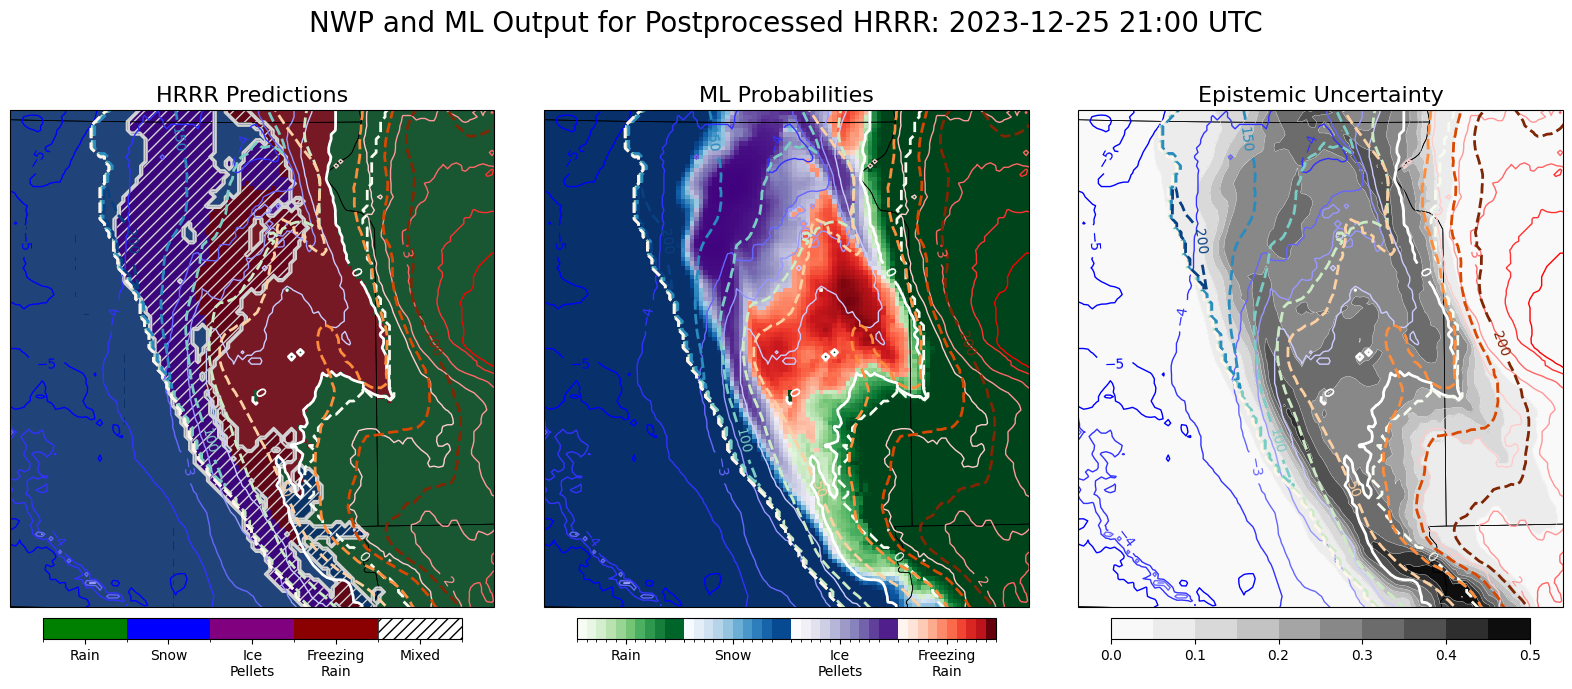

In [33]:
plt.rcParams['hatch.color'] = 'lightgrey'
lcc = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5))
                            # globe=ccrs.Globe(semimajor_axis=6370000, semiminor_axis=6370000))
fig, axes = plt.subplots(1, 3, figsize=(16, 6), subplot_kw={'projection': lcc}, constrained_layout=True)
for ax in axes.ravel():
    # axes.set_extent([-103, -88, 35, 48.4], crs=ccrs.PlateCarree())
    ax.set_extent([-99.5, -95.5, 43, 46], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES, linewidth=0.5)
cmaps = ["Greens", "Blues", "Purples", "Reds"]

colors = ['darkgreen', 'darkblue', 'violet', 'darkred']
titles = ['Rain', 'Snow', 'Ice Pellets', 'Freezing Rain']
a_max = ds['aleatoric'].max()
u_max = ds['ML_u'].max()
zorders = [4, 3, 2, 1]
for i, pt in enumerate(ptypes):
    # axes[i].contour(ds['longitude'], ds['latitude'], ds[f"wb_2m"].values)
    # p = axes[0].contourf(ds['longitude'], ds['latitude'], ds[f"ML_{pt}_cp"], cmap=cmaps[i], levels=np.linspace(0, 1, 21), vmin=0, vmax=1, transform=ccrs.PlateCarree(), antialiased=False)
    p = axes[1].pcolormesh(ds['longitude'], ds['latitude'], ds[f"ML_{pt}_cp"], cmap=cmaps[i], vmin=0.25, vmax=0.8, transform=ccrs.PlateCarree(), antialiased=False)
    # p2 = axes[1].contourf(ds['longitude'], ds['latitude'], ds[f"c{pt}"], colors=colors[i], transform=ccrs.PlateCarree(), alpha=1)
    p2 = axes[0].pcolormesh(ds['longitude'], ds['latitude'], ds[f"c{pt}"], cmap=cmaps[i], vmin=0, vmax=1, transform=ccrs.PlateCarree(), alpha=0.9)
    # axes[1].contourf(ds['longitude'], ds['latitude'], ds[f"c{pt}"], colors=colors[i], vmin=0, vmax=1, transform=ccrs.PlateCarree(), alpha=0.9)

axes[0].contour(ds['longitude'], ds['latitude'], hrrr_mixed, colors='lightgrey', levels=1, transform=ccrs.PlateCarree())
axes[0].contourf(ds['longitude'], ds['latitude'], hrrr_mixed, colors='lightgrey', levels=2, hatches=[None, None, '///'], transform=ccrs.PlateCarree(), alpha=0)
p3 = axes[2].contourf(ds['longitude'], ds['latitude'], ds[f"ML_u"], cmap="Greys", levels=np.linspace(0, 0.5, 11), vmin=0, vmax=0.5, transform=ccrs.PlateCarree())
axes[2].contour(ds['longitude'], ds['latitude'], ds[f"ML_u"], colors='w', levels=np.linspace(0, 0.5, 11), linewidths=0.3, transform=ccrs.PlateCarree())
# p4 = axes[3].contourf(ds['longitude'], ds['latitude'], ds[f"aleatoric"], cmap="Greys", levels=np.linspace(0, a_max, 21), vmin=0, vmax=a_max, transform=ccrs.PlateCarree())
# axes[3].contour(ds['longitude'], ds['latitude'], ds[f"aleatoric"], colors='w', levels=np.linspace(0, a_max, 21), linewidths=0.3, transform=ccrs.PlateCarree())
for i in range(3):
    # d = axes[i].contour(ds['longitude'], ds['latitude'], ds[f"d2m"].values - 273.15, transform=ccrs.PlateCarree(), cmap='Greens', linestyles='--', levels=np.linspace(-5, 5, 6), vmin=-5, vmax=5, linewidths=1.5)
    c = axes[i].contour(ds['longitude'], ds['latitude'], ds[f"t2m"].values - 273.15, transform=ccrs.PlateCarree(), cmap='bwr', linestyles='-', levels=np.linspace(-5, 5, 11), vmin=-5, vmax=5, linewidths=1)
    # d1 = axes[i].contour(ds['longitude'], ds['latitude'], ds[f"d2m"].values - 273.15, transform=ccrs.PlateCarree(), colors='w', linestyles='--', levels=[0], linewidths=2.5)
    c1 = axes[i].contour(ds['longitude'], ds['latitude'], ds[f"t2m"].values -273.15, transform=ccrs.PlateCarree(), colors='w', linestyles='-', levels=[0], linewidths=2)
    f = axes[i].contour(ds['longitude'], ds['latitude'], ds[f"freeze_energy"].values, transform=ccrs.PlateCarree(), cmap='GnBu', linestyles='--', levels=np.linspace(0, 200, 5), vmin=0, vmax=200, linewidths=2)
    f1 = axes[i].contour(ds['longitude'], ds['latitude'], ds[f"melt_energy"].values, transform=ccrs.PlateCarree(), cmap='Oranges', linestyles='--', levels=np.linspace(0, 200, 5), vmin=0, vmax=200, linewidths=2, label="Melt Energy")
    # wn = axes[i].contour(ds['longitude'], ds['latitude'], ds[f"warm_nose_max_temp"].values, transform=ccrs.PlateCarree(), colors='yellow', linestyles='--', levels=np.linspace(0, 3, 7), vmin=0, vmax=3, linewidths=2)

    axes[i].clabel(c)
    axes[i].clabel(f)
    axes[i].clabel(c1)
    # axes[i].clabel(wn)
    axes[i].clabel(f1)
    # plt.legend(f1)
# plt.colorbar(p, ax=axes[0], shrink=0.8, orientation='horizontal', pad=0.02)
cbar = plt.colorbar(sm, ax=axes[1], ticks=np.arange(0.5, num_cmaps + 0.5, 1), shrink=0.8, orientation='horizontal', pad=0.02)
cbar.set_ticklabels(['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain'])
# plt.colorbar(cbar2, ax=axes[1], shrink=0.8, orientation='horizontal', pad=0.02)
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes[0],
    orientation='horizontal',
    boundaries=bounds,
    ticks=np.arange(0.5, 5.5),
    spacing='proportional',
    pad=0.02,
    shrink=0.8
)
# Overlay hatched box on last bin (MIXED)
xticks = cb.ax.get_xticks()
tickwidth = xticks[1] - xticks[0]
x = xticks[4] - tickwidth / 2
width = tickwidth

hatched_rect = mpatches.Rectangle(
    (x, 0), width, 1,
    transform=cb.ax.transData,
    facecolor='none',       # transparent
    edgecolor='black',
    hatch='///',
    linewidth=0.5
)
cb.ax.add_patch(hatched_rect)

cb.set_ticklabels(['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain', 'Mixed'])
plt.colorbar(p3, ax=axes[2], shrink=0.8, orientation='horizontal', pad=0.02, spacing='proportional')
# plt.colorbar(p4, ax=axes[3], shrink=0.8, orientation='horizontal', pad=0.02)
axes[1].set_title('ML Probabilities', fontsize=16)
axes[0].set_title('HRRR Predictions', fontsize=16)
axes[2].set_title('Epistemic Uncertainty', fontsize=16)
# axes[3].set_title('ML Aleatoric Uncertainty', fontsize=16)
plt.suptitle('NWP and ML Output for Postprocessed HRRR: 2023-12-25 21:00 UTC', fontsize=20, y=1.12)
# plt.tight_layout()
plt.savefig('/glade/derecho/scratch/cbecker/ptype_paper/figures/spatial.png', dpi=300, bbox_inches='tight')

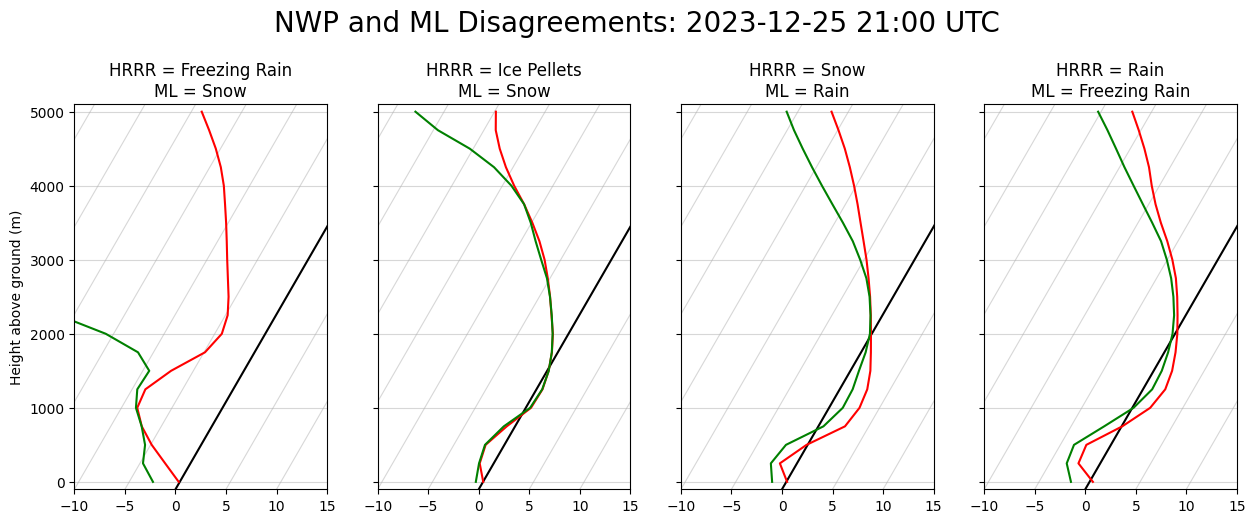

In [34]:
hrrr_cats = ['cfrzr', 'cicep', 'csnow', 'crain']
ml_cats = ['ML_csnow', 'ML_csnow', 'ML_crain', 'ML_cfrzr']
ii = [100, 0, -1, 70]
ds['c_all'] = ds[['crain', 'csnow', 'cicep', 'cfrzr']].to_array().sum('variable')
d_map = {'crain': 'Rain', 'csnow': 'Snow', 'cicep': 'Ice Pellets', 'cfrzr': 'Freezing Rain', 'ML_crain': 'Rain', 'ML_csnow': 'Snow', 'ML_cicep': 'Ice Pellets', 'ML_cfrzr': 'Freezing Rain'}

fig, sfig, axs = skewCompositeFigAx(figsize=(15, 5), num_subplots=4)
for ix in range(4):
    hrrr_cat = hrrr_cats[ix]
    ml_cat = ml_cats[ix]
    indices = np.argwhere((ds[hrrr_cat] == 1).values & (ds['c_all'] == 1).values & (ds[ml_cat] == 1).values)
    i = ii[ix]
    y, x = indices[i]
    height = ds['heightAboveGround'].values
    T = ds['t_h'].isel(y=y, x=x)
    Td = ds['dpt_h'].isel(y=y, x=x)
    
    axs[ix].plot(T, height, color='r', linestyle='-', label='FRZR TMP')
    axs[ix].plot(Td, height, color='g', linestyle='-', label='FRZR DPT')
    axs[ix].set_title(f"HRRR = {d_map[hrrr_cat]}\nML = {d_map[ml_cat]}")
fig.suptitle('NWP and ML Disagreements: 2023-12-25 21:00 UTC', fontsize=20, y=1.07)
plt.savefig('/glade/derecho/scratch/cbecker/ptype_paper/figures/sounding_disagree.png', dpi=300, bbox_inches='tight')

In [35]:
%%time
base_path = "/glade/derecho/scratch/cbecker/ptype_real_time/full_central_region/hrrr/"
start = "20231225"
end = "20231227"
ASOS_station_ID = "ABR"
f = get_analysis_files(base_path, start, end)
ds = xr.open_mfdataset(f, concat_dim='time', combine='nested', engine='h5netcdf', decode_timedelta=True, parallel=True)
# df = fetch('ABR', "20231225", "20231228", report_type=[3, 4], subsample=False, freq="15min")
df_resample = fetch(ASOS_station_ID, start, end, report_type=[1], subsample=True, freq="15min")
df = fetch(ASOS_station_ID, start, end, report_type=[3, 4], subsample=False, freq="15min")
ds_point = match_latlon(ds, df['lat'].iloc[0], df['lon'].iloc[0])
ds_point

<timed exec>:6: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.


350 325
CPU times: user 21.2 s, sys: 1.95 s, total: 23.2 s
Wall time: 37.5 s


<xarray.Dataset> Size: 78kB
Dimensions:            (time: 49, heightAboveGround: 21, isobaricInhPa: 40)
Coordinates:
  * time               (time) datetime64[ns] 392B 2023-12-24T23:00:00 ... 202...
  * heightAboveGround  (heightAboveGround) int64 168B 0 250 500 ... 4750 5000
  * isobaricInhPa      (isobaricInhPa) float32 160B 1.013e+03 1e+03 ... 50.0
    step               timedelta64[ns] 8B 01:00:00
    latitude           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    longitude          float32 4B dask.array<chunksize=(), meta=np.ndarray>
    valid_time         (time) datetime64[ns] 392B 2023-12-25 ... 2023-12-27
    atmosphere         float32 4B 0.0
    meanSea            float32 4B 0.0
Data variables: (12/41)
    t_h                (time, heightAboveGround) float32 4kB dask.array<chunksize=(1, 11), meta=np.ndarray>
    dpt_h              (time, heightAboveGround) float32 4kB dask.array<chunksize=(1, 11), meta=np.ndarray>
    u_h                (time, heightAboveGround) float32 4kB dask.array<chunksize=(1, 11), meta=np.ndarray>
    v_h                (time, heightAboveGround) float32 4kB dask.array<chunksize=(1, 11), meta=np.ndarray>
    isobaricInhPa_h    (time, heightAboveGround) float64 8kB dask.array<chunksize=(1, 11), meta=np.ndarray>
    t                  (time, isobaricInhPa) float32 8kB dask.array<chunksize=(1, 20), meta=np.ndarray>
    ...                 ...
    ML_snow            (time) float32 196B dask.array<chunksize=(1,), meta=np.ndarray>
    ML_csnow           (time) uint8 49B dask.array<chunksize=(1,), meta=np.ndarray>
    ML_icep            (time) float32 196B dask.array<chunksize=(1,), meta=np.ndarray>
    ML_cicep           (time) uint8 49B dask.array<chunksize=(1,), meta=np.ndarray>
    ML_frzr            (time) float32 196B dask.array<chunksize=(1,), meta=np.ndarray>
    ML_cfrzr           (time) uint8 49B dask.array<chunksize=(1,), meta=np.ndarray>

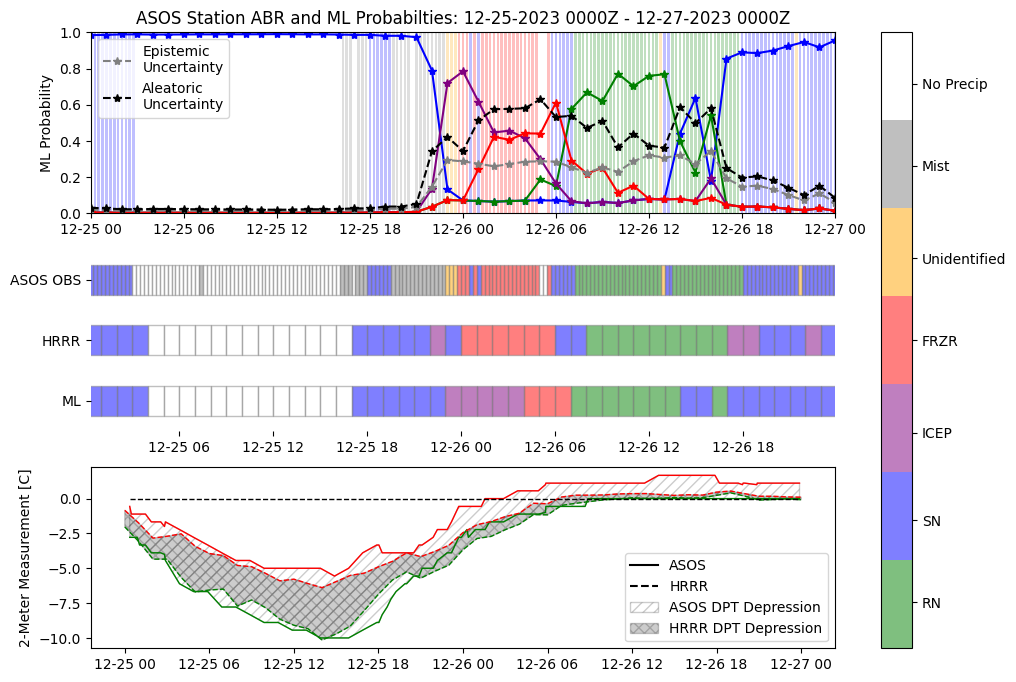

In [36]:
nwp_colors = ['white'] * ds_point.time.size
ml_colors = ['white'] * ds_point.time.size
nwp_vars = ['crain', 'csnow', 'cicep', 'cfrzr']
ml_vars = ['ML_crain', 'ML_csnow', 'ML_cicep', 'ML_cfrzr']
for c, color in enumerate(['green', 'blue', 'purple', 'red']):
    nwp_ix = np.argwhere(ds_point[nwp_vars[c]].values == 1).flatten()
    for i in nwp_ix:
        nwp_colors[i] = color
    ml_ix = np.argwhere(ds_point[ml_vars[c]].values == 1).flatten()
    for i in ml_ix:
        ml_colors[i] = color
for i, c in enumerate(nwp_colors):
    if c == 'white':
        ml_colors[i] = 'white'

asos_line = mlines.Line2D([], [], color='black', linestyle='-', label='ASOS')
hrrr_line = mlines.Line2D([], [], color='black', linestyle='--', label='HRRR')

dates = ds_point['valid_time'].values
obs_dates = df.index[(df.index >= dates[0]) & (df.index <= dates[-1])]
obs_dates_resample = df_resample.index[(df_resample.index >= dates[0]) & (df_resample.index <= dates[-1])]
data = df.loc[obs_dates]
data_resample = df_resample.loc[obs_dates_resample]
ale_total = ds_point[["ML_rain_ale", "ML_snow_ale", "ML_icep_ale", "ML_frzr_ale"]].to_array().sum(dim='variable')
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
# ax1.xaxis.set_major_locator(mdates.HourLocator())
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
c = np.arange(1, 8)
cmap = ListedColormap(['g', 'b', 'purple', 'r', 'orange', "grey", 'w'])
colors = ['g', 'b', 'purple', 'r']
labels = ('RN', 'SN', 'ICEP', 'FRZR', 'Unidentified', "Mist", 'No Precip')
dummie_cax = ax[0].scatter(c, c, c=c, cmap=cmap)
ax[0].cla()
ax[0].bar(x=obs_dates_resample, height=data_resample['dummy_height'], width=pd.Timedelta(minutes=10), edgecolor=None, color=data_resample['color_code'], alpha=0.25)
ax[0].set_xlim(obs_dates_resample[0], obs_dates_resample[-1])

ax[0].plot(dates, ds_point['ML_snow'].values, "*-", color='b')
ax[0].plot(dates, ds_point['ML_rain'].values, "*-", color='g')
ax[0].plot(dates, ds_point['ML_icep'].values, "*-", color='purple')
ax[0].plot(dates, ds_point['ML_frzr'].values, "*-", color='r')
ax[0].plot(dates, ds_point['ML_u'].values, "*--", color='grey', label='Epistemic\nUncertainty')
ax[0].plot(dates, ale_total.values, "*--", color='k', label='Aleatoric\nUncertainty')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('ML Probability')
ax[0].legend()

ax[1].barh(0.7, left=obs_dates_resample, width=pd.Timedelta("15min"), height=0.1, color=data_resample['color_code'].values, edgecolor='grey', alpha=0.5)
ax[1].barh(0.5, left=dates, width=pd.Timedelta("60min"), height=0.1, color=nwp_colors, edgecolor='grey', alpha=0.5)
ax[1].barh(0.3, left=dates, width=pd.Timedelta("60min"), height=0.1, color=ml_colors, edgecolor='grey', alpha=0.5)
ax[1].set_xlim(obs_dates[0], obs_dates[-1])
ax[1].set_ylim(0.2, 0.8)
ax[1].set_yticks([0.3, 0.5, 0.7])
ax[1].set_yticklabels(['ML', 'HRRR', 'ASOS OBS'])
ax[1].set_frame_on(False)

ax[2].plot(obs_dates, data['tmpc'], color='r', linewidth=1)
ax[2].plot(obs_dates, data['dwpc'], color='g', linewidth=1)
ax[2].plot(ds_point['valid_time'].values, ds_point['t2m'] - 273.15, color='r', linewidth=1, linestyle="--")
ax[2].plot(ds_point['valid_time'].values, ds_point['d2m'] - 273.15 , color='g', linewidth=1, linestyle="--")

ax[2].fill_between(obs_dates, data['tmpc'], data['dwpc'], alpha=0.2, hatch="///", color='k', facecolor='w', label='ASOS DPT Depression')
ax[2].fill_between(ds_point['valid_time'].values, ds_point['t2m'].values - 273.15, ds_point['d2m'].values - 273.15, color='k', hatch="xxx", facecolor='k', alpha=0.2, label='HRRR DPT Depression')
ax[2].set_ylabel('2-Meter Measurement [C]')
ax[2].plot(obs_dates, np.zeros(len(obs_dates)), "--k", linewidth=1)
# ax[2].legend()
ax[2].legend(handles=[asos_line, hrrr_line] + plt.gca().get_legend_handles_labels()[0])
# plt.legend()
cbar = fig.colorbar(dummie_cax, ticks=c, ax=ax, alpha=0.5)
cbar.set_ticks([1.45, 2.25, 3.1, 4, 4.8, 5.7, 6.5])
cbar.ax.set_yticklabels(labels)
cbar.solids.set(alpha=0.5)
# cbar.set_label('ASOS Station Reports', rotation=270,labelpad=-90)
ax[0].set_title('ASOS Station ABR and ML Probabilties: 12-25-2023 0000Z - 12-27-2023 0000Z')
plt.savefig('/glade/derecho/scratch/cbecker/ptype_paper/figures/ptype_obs_comparison_new.png', dpi=300, bbox_inches="tight")
plt.show()